In [1]:
import neuromaps
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0.0.5+41.gf0ed67c


In [2]:
## run if needed
# pip install neuromaps brainspace

In [3]:
# Add more imports if needed

from neuromaps.datasets import fetch_atlas ## used to access the templates for the coordinate system
import nibabel as nib ## used to load system dictionary per key
from neuromaps.datasets import available_annotations ## repository of brain maps - spatial maps representing some
from neuromaps.datasets import available_tags ## most annotations have “tags” that help to describe the data they represent
from neuromaps.datasets import fetch_annotation
from neuromaps.datasets import fetch_fsaverage
from neuromaps import transforms
import netneurotools
# possibly need
from netneurotools import datasets as nntdata
from neuromaps import parcellate
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
# plotting 
from neuromaps.images import load_data
import matplotlib.pyplot as plt
from neuromaps import plotting
from nilearn import plotting
import numpy as np
# sampling
from neuromaps import datasets, images, nulls, resampling
from neuromaps.resampling import resample_images
from neuromaps.stats import compare_images
from scipy.spatial.distance import cosine
from neuromaps import stats
from nilearn.datasets import fetch_atlas_surf_destrieux
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from scipy.stats import pearsonr

from nilearn.surface import load_surf_mesh
from brainspace.null_models import SpinPermutations
from nilearn.surface import InMemoryMesh, PolyMesh
from nilearn.surface import SurfaceImage
from nilearn.plotting import view_surf

import time


import pandas as pd
from matplotlib.lines import Line2D


In [4]:
# for annotation in available_annotations():
#     print(annotation)

### Our Source Map

In [4]:
## note this map is 164k density
evo_map = fetch_annotation(source='hill2010', desc='evoexp', space='fsLR', den='164k')
print(evo_map)
# evo map is string where data for this brain map is stored


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
/Users/kevin/neuromaps-data/annotations/hill2010/evoexp/fsLR/source-hill2010_desc-evoexp_space-fsLR_den-164k_hemi-R_feature.func.gii


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_69874/3873946080.py:34: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_69874/3873946080.py:41: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


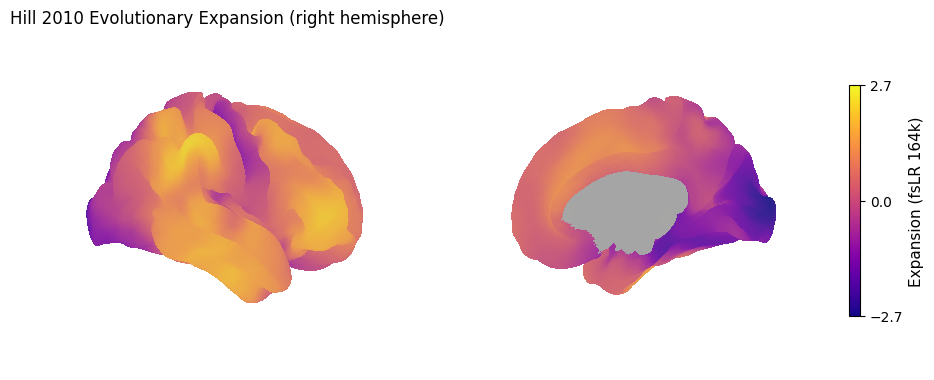

In [19]:
# if isinstance(evo_map, str):
#     rh_path = evo_map # string of the file path
# elif isinstance(evo_map, (list, tuple)):
#     rh_path = [p for p in evo_map if 'hemi-R' in str(p)]
#     rh_path = rh_path[0] if rh_path else evo_map[0]
# else:
#     raise ValueError("Unexpected evo_map format:", evo_map)
# print("Right hemisphere file:", rh_path)

# load the data for the right hemi 
rh_data = load_data(evo_map)

# fetches brain surface options for plotting
fslr = fetch_atlas('fsLR', density='164k')
surf_r = fslr['midthickness'].R # choose mid thickness for right hemi

vmin, vmax = -2.7, 2.7

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    surf_mesh=surf_r,
    surf_map=rh_data,
    hemi='right',
    cmap='plasma',
    bg_on_data=True,
    vmin=vmin,
    vmax=vmax,
    colorbar=False
)
# plot right veiw
plotting.plot_surf(
    view='lateral',
    axes=ax1,
    title='Hill 2010 Evolutionary Expansion (right hemisphere)',
    **plot_kwargs
)
# plot from left view
plotting.plot_surf(
    view='medial',
    axes=ax2,
    **plot_kwargs
)

sm = plt.cm.ScalarMappable(cmap='plasma')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Expansion (fsLR 164k)', fontsize=11)
cbar.set_ticks([-2.7, 0, 2.7])

plt.show()

In [6]:
# ls ~/neuromaps-data/annotations/hill2010/evoexp/fsLR/

### Target Maps
There are 12
1. PC1 Gene Expression
2. T1w/T2w ratio (Myelin)
3. Cortical Thickness
4. Developmental expansion
5. Functional gradient
6. Intersubject variability
7. Cerebral blood flow
8. Cerebral blood volume
9. Oxygen metabolism
10. Glucose metabolism
11. Allometric scaling NIH
12. Allometric scaling PNC

In [7]:
# Kevin S will be working with these
('abagen', 'genepc1', 'fsaverage', '10k') # PC1 gene expression
('hcps1200', 'myelinmap', 'fsLR', '32k') # myelin maps - T1w/T2w ratio
('hcps1200', 'thickness', 'fsLR', '32k') # cortical thickness
('hill2010', 'devexp', 'fsLR', '164k') # dev expansion
('margulies2016', 'fcgradient01', 'fsLR', '32k') # functional development
('mueller2013', 'intersubjvar', 'fsLR', '164k') # intersubject functional variability

('mueller2013', 'intersubjvar', 'fsLR', '164k')

In [8]:
# target_maps = {
#     'pc1 gene exp': {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
#     'T1w/T2w ratio': {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
#     'cortical thickness': {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
#     'devexp': {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'},
#     'func gradient': {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
#     'intersubjvar': {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}
# }

In [9]:
# Kevin H will be working with these
('raichle', 'cbf', 'fsLR', '164k') # cerebral blood flow
('raichle', 'cbv', 'fsLR', '164k') # cerebral blood volume
('raichle', 'cmr02', 'fsLR', '164k') # oxygen metabolism CMRO2
('raichle', 'cmrglc', 'fsLR', '164k') # glucose metabolism GMRGlu
('reardon2018', 'scalingpnc', 'civet', '41k') #  allometric scaling PNC
('reardon2018', 'scalingnih', 'civet', '41k') # allometric scaling NIH

('reardon2018', 'scalingnih', 'civet', '41k')

In [5]:
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
# genepc1


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_69874/193458405.py:24: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_69874/193458405.py:35: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


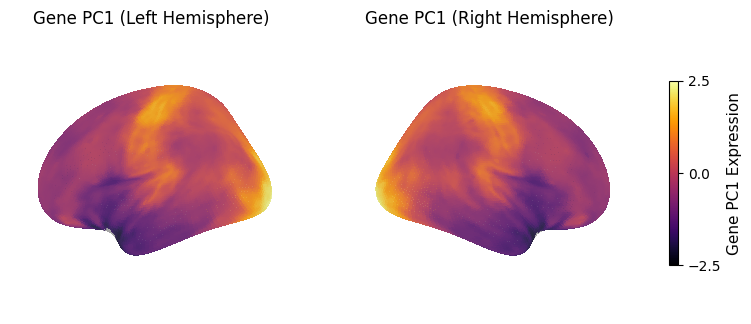

In [ ]:
# Gene PC1 brain map plotting

# fetch brain meshes of density 10k for plotting
fsavg = fetch_fsaverage(density='10k')

# load data from GIFTI files
lh_data = load_data(genepc1[0])
rh_data = load_data(genepc1[1])

vmin, vmax = -2.5, 2.5   # adjust if needed for better contrast

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    cmap='inferno',
    bg_on_data=True,
    vmin=vmin, vmax=vmax,
    colorbar=False
)

# left hemi
plotting.plot_surf(
    surf_mesh=fsavg['inflated'].L,
    surf_map=lh_data,
    hemi='left',
    view='lateral',
    axes=ax1,
    title='Gene PC1 (Left Hemisphere)',
    **plot_kwargs
)

# right hemi
plotting.plot_surf(
    surf_mesh=fsavg['inflated'].R,
    surf_map=rh_data,
    hemi='right',
    view='lateral',
    axes=ax2,
    title='Gene PC1 (Right Hemisphere)',
    **plot_kwargs
)
# colorbar for both plots
sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Gene PC1 Expression', fontsize=11)
cbar.set_ticks([vmin, 0, vmax])

plt.show()

In [6]:
T1w_T2w_ratio = fetch_annotation(source='hcps1200', desc='myelinmap',space='fsLR', den='32k')
# T1w_T2w_ratio


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


In [7]:
cortical_thickness = fetch_annotation(source= 'hcps1200', desc= 'thickness', space='fsLR', den='32k')
# cortical_thickness


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


In [8]:
dev_expansion = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
# dev_expansion


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


In [9]:
func_gradient = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
# func_gradient


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


In [10]:
intersub_func_var = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
# intersub_func_var


[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    


In [17]:
# if isinstance(evo_map, str):
#     rh_path = evo_map
# elif isinstance(evo_map, (list, tuple)):
#     rh_path = evo_map[0]
# else:
#     raise ValueError("Unexpected evo_map format: ", evo_map)
# print("Right hemisphere file:", rh_path)

# rh_data = load_data(rh_path)
# print("Right hemisphere data shape:", rh_data.shape)

# fslr = fetch_atlas('fsLR', density='164k')
# surf_r = fslr['midthickness'].R

# plotting.plot_surf(
#     surf_mesh=surf_r,
#     surf_map=rh_data,
#     hemi='right',
#     view='lateral',
#     # cmap='Spectral_r',
#     colorbar=True,
#     bg_on_data=True,
#     title='Hill 2010 Evolutionary Expansion (RH, fsLR-164k)'
# )
# plt.show()

In [18]:
# if isinstance(evo_map, str):
#     rh_path = evo_map
# elif isinstance(evo_map, (list, tuple)):
#     rh_path = evo_map[0]
# else:
#     raise ValueError("Unexpected evo_map format: ", evo_map)
# print("Right hemisphere file:", rh_path)

# rh_data = load_data(rh_path)
# print("Right hemisphere data shape:", rh_data.shape)

# fslr = fetch_atlas('fsLR', density='164k')
# surf_r = fslr['midthickness'].R

# plotting.plot_surf(
#     surf_mesh=surf_r,
#     surf_map=rh_data,
#     hemi='right',
#     view='medial',
#     cmap='viridis',
#     colorbar=True,
#     bg_on_data=True,
#     title='Hill 2010 Evolutionary Expansion (RH, fsLR-164k)'
# )
# plt.show()

### Transform Source map into same Surface Spaces as target Maps
### Spin Test

In [12]:
results_dict = {'target map':[], 
                'r_emp':[], 
                'p_spin':[], 
                'nulls':[]
               }
# dict to be used to make box plots later

In [13]:
## OG Code for gene PC1 correlation with source map

# transform source map to fsaverage 10k
evo_in_fsaverage10k = transforms.fslr_to_fsaverage(evo_map, '10k', hemi='R')
# load the data --> bascially reads in the .func.gii file and returns the data array
evo_data_r = load_data(evo_in_fsaverage10k[0])
genepc1_r = load_data(genepc1[1]) # right hemi

# make left hemi NaN's so spin test works for built in function
evo_full = np.concatenate([np.full_like(evo_data_r, np.nan), evo_data_r])
genepc1_full = np.concatenate([np.full_like(genepc1_r, np.nan), genepc1_r])

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(genepc1_full)
r_emp, _ = pearsonr(evo_full[mask], genepc1_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fsaverage',
    density='10k',
    n_perm=1000
)

# empirical r to null
# compare_images() compares the two maps and the nulls --> outputs r, p value, and null distribution
r_emp_gene, p_spin_gene, nulls_gene = compare_images(
    evo_full,
    genepc1_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True # null distribution for boxplot later
)
print(f"Spatial correlation for Gene Expression = {r_emp_gene:.3f}, spin test p = {p_spin_gene:.4f}")

#---------------
results_dict['target map'].append('PC1 Gene Expression')
results_dict['r_emp'].append(r_emp_gene)
results_dict['p_spin'].append(p_spin_gene)
results_dict['nulls'].append(nulls_gene)

Empirical correlation = -0.510
Spatial correlation for Gene Expression = -0.512, spin test p = 0.0360


In [ ]:
# ## genepc1 USING SPIN PERMUTATIONS

# # transform the data
# evo_in_fsaverage10k = transforms.fslr_to_fsaverage(evo_map, '10k', hemi='R')
# # load_data bascially reads in the .func.gii file and returns the data array
# evo_r = load_data(evo_in_fsaverage10k[0])
# tgt_r = load_data(genepc1[1])  # right hemi

# # download the brain surface (template of brain's shape)
# fslr_32k = fetch_atlas('fsaverage', density='10k') # outputs dictionary diff templates for fsLR 32k
# sphere_r_path = fslr_32k['sphere'].R # want the sphere for right hemi
# coords, faces = load_surf_mesh(sphere_r_path) # actually reads the surface mesh --> outputs coordinates(vertcex points) and faces (triangles)
# assert evo_r.shape[0] == tgt_r.shape[0] == coords.shape[0]

# # empircal corr
# mask = ~np.isnan(evo_r) & ~np.isnan(tgt_r) # only get valid data
# r_emp_myelin, _ = pearsonr(evo_r[mask], tgt_r[mask])
# print(f"Empirical correlation = {r_emp_myelin:.3f}")

# # spin permutations
# # doing this instead of alexander_bloch()
# n_perm = 1000
# sp = SpinPermutations(n_rep=n_perm) # spin the surface
# sp.fit(coords[mask]) 
# permuted = sp.randomize(evo_r[mask]) # 1000 null version of source map
# # list of correlations
# null_r_myelin = np.array([
#     pearsonr(permuted[i], tgt_r[mask])[0]
#     for i in range(n_perm)
# ])
# # see if r is significant
# p_myelin = (np.sum(np.abs(null_r_myelin) >= np.abs(r_emp_myelin)) + 1) / (n_perm + 1)
# print(f"Spin test (hemisphere) r = {r_emp_myelin:.3f}, p = {p_myelin:.4f}")

# #---------------
# results_dict['target map'].append('New PC1 gene Exp')
# results_dict['r_emp'].append(r_emp_myelin)
# results_dict['p_spin'].append(p_myelin)
# results_dict['nulls'].append(null_r_myelin)
# results_dict['target map']


# # alexander_bloch() is the function that auto spins both hemispheres --> outputs 2D array and doesn't give null distribution
# # compare_images() compares the two maps and the nulls --> outputs r and p value (one hemi) but don'est given null distribution
# # SpinPermutations manual spin of a hemisphere --> putputs correaltion values for each permutations (1d array) and gives nulls dist for boxplot

Empirical correlation = -0.510
Spin test (hemisphere) r = -0.510, p = 0.0370


['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Developmental Expansion',
 'Functional Gradient',
 'Intersubject Variability',
 'New PC1 gene Exp']

In [ ]:
## myelin map

# transofrm the data
evo_in_fsLR32k = transforms.fslr_to_fslr(evo_map, '32k', hemi='R')
# load_data bascially reads in the .func.gii file and returns the data array
evo_r = load_data(evo_in_fsLR32k)
tgt_r = load_data(T1w_T2w_ratio[1]) # right hemi

# download the brain surface (template of brain's shape)
fslr_32k = fetch_atlas('fsLR', density='32k') # outputs dictionary diff templates for fsLR 32k
sphere_r_path = fslr_32k['sphere'].R # want the sphere for right hemi
coords, faces = load_surf_mesh(sphere_r_path) # actually reads the surface mesh --> outputs coordinates(vertcex points) and faces (triangles)
assert evo_r.shape[0] == tgt_r.shape[0] == coords.shape[0]

# empircal corr
mask = ~np.isnan(evo_r) & ~np.isnan(tgt_r)
r_emp_myelin, _ = pearsonr(evo_r[mask], tgt_r[mask])
print(f"Empirical correlation = {r_emp_myelin:.3f}")

# spin permutations
# have to do this instead of alexander_bloch()
n_perm = 1000
sp = SpinPermutations(n_rep=n_perm)
sp.fit(coords[mask])
permuted = sp.randomize(evo_r[mask])

# null listof corrs
null_r_myelin = np.array([
    pearsonr(permuted[i], tgt_r[mask])[0]
    for i in range(n_perm)
])
# see if r is significant
p_myelin = (np.sum(np.abs(null_r_myelin) >= np.abs(r_emp_myelin)) + 1) / (n_perm + 1)
print(f"Spin test (hemisphere) r = {r_emp_myelin:.3f}, p = {p_myelin:.4f}")

#---------------
results_dict['target map'].append('T1w/T2w Ratio')
results_dict['r_emp'].append(r_emp_myelin)
results_dict['p_spin'].append(p_myelin)
results_dict['nulls'].append(null_r_myelin)
results_dict['target map']

Empirical correlation = -0.040
Spin test (hemisphere) r = -0.040, p = 0.8531


In [19]:
## cortical thickness
evo_in_fsLR32k = transforms.fslr_to_fslr(evo_map, '32k', hemi='R')
evo_r = load_data(evo_in_fsLR32k)
tgt_r = load_data(cortical_thickness[1])

fslr_32k = fetch_atlas('fsLR', density='32k')
sphere_r_path = fslr_32k['sphere'].R 
coords, faces = load_surf_mesh(sphere_r_path)
assert evo_r.shape[0] == tgt_r.shape[0] == coords.shape[0]

# empircal corr
mask = ~np.isnan(evo_r) & ~np.isnan(tgt_r)
r_emp_cort_thick, _ = pearsonr(evo_r[mask], tgt_r[mask])
print(f"Empirical correlation = {r_emp_cort_thick:.3f}")

# spin permutations
n_perm = 1000
sp = SpinPermutations(n_rep = n_perm)
sp.fit(coords[mask])
permuted = sp.randomize(evo_r[mask])

# null
null_r_cort_thick = np.array([
    pearsonr(permuted[i], tgt_r[mask])[0]
    for i in range(n_perm)
])

p_cort_thick = (np.sum(np.abs(null_r_cort_thick) >= np.abs(r_emp_cort_thick)) + 1) / (n_perm + 1)
print(f"Spin test (hemisphere) r = {r_emp_cort_thick:.3f}, p = {p_cort_thick:.4f}")
#---------------
results_dict['target map'].append('Cortical Thickness')
results_dict['r_emp'].append(r_emp_cort_thick)
results_dict['p_spin'].append(p_cort_thick)
results_dict['nulls'].append(null_r_cort_thick)
results_dict['target map']

Empirical correlation = 0.247
Spin test (hemisphere) r = 0.247, p = 0.2128


['PC1 Gene Expression', 'T1w/T2w Ratio', 'Cortical Thickness']

In [22]:
## Functional Gradient
evo_in_fsLR32k = transforms.fslr_to_fslr(evo_map, '32k', hemi='R')

evo_r = load_data(evo_in_fsLR32k)
tgt_r = load_data(func_gradient[1])

# For fsLR 32k:
fslr_32k = fetch_atlas('fsLR', density='32k')
sphere_r_path = fslr_32k['sphere'].R 
coords, faces = load_surf_mesh(sphere_r_path)
assert evo_r.shape[0] == tgt_r.shape[0] == coords.shape[0]

# empircal corr
mask = ~np.isnan(evo_r) & ~np.isnan(tgt_r)
r_emp_fg, _ = pearsonr(evo_r[mask], tgt_r[mask])
print(f"Empirical correlation = {r_emp_fg:.3f}")

# spin permutations
n_perm = 1000
sp = SpinPermutations(n_rep = n_perm)
sp.fit(coords[mask])
permuted = sp.randomize(evo_r[mask])

# null
null_r_func_grad = np.array([
    pearsonr(permuted[i], tgt_r[mask])[0]
    for i in range(n_perm)
])

p_func_grad = (np.sum(np.abs(null_r_func_grad) >= np.abs(r_emp_fg)) + 1) / (n_perm + 1)
print(f"Spin test (hemisphere) r = {r_emp_fg:.3f}, p = {p_func_grad:.4f}")

#---------------
results_dict['target map'].append('Functional Gradient')
results_dict['r_emp'].append(r_emp_fg)
results_dict['p_spin'].append(p_func_grad)
results_dict['nulls'].append(null_r_func_grad)
results_dict['target map']

Empirical correlation = 0.334
Spin test (hemisphere) r = 0.334, p = 0.0799


['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Developmental Expansion',
 'Functional Gradient']

In [15]:
## intersubject variability
# both are in the same dimension already --> no need to transform

evo_data_r = load_data(evo_map)
ISV_r = load_data(intersub_func_var[1]) # right hemi

# make left hemi NaN's so spin test works
evo_full = np.concatenate([np.full_like(evo_data_r, np.nan), evo_data_r])
ISV_full = np.concatenate([np.full_like(ISV_r, np.nan), ISV_r])

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(ISV_full)
r_emp, _ = pearsonr(evo_full[mask], ISV_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fsLR',
    density='164k',
    n_perm=1000
)

# empirical r to null
r_emp_ISV, p_spin_ISV, nulls_ISV = compare_images(
    evo_full,
    ISV_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True
)
print(f"Spatial correlation for Intersubject Variability = {r_emp_ISV:.3f}, spin test p = {p_spin_ISV:.4f}")

#---------------
results_dict['target map'].append('Intersubject Variability')
results_dict['r_emp'].append(r_emp_ISV)
results_dict['p_spin'].append(p_spin_ISV)
results_dict['nulls'].append(nulls_ISV)

Empirical correlation = 0.575
Spatial correlation for Intersubject Variability = 0.575, spin test p = 0.0020


In [ ]:
# ## intersubject variability using Spin Permutations

# start_time = time.time()

# # both are fsLR 164k --> no transformation needed
# evo_data_r = load_data(evo_map)
# intersub_func_var_r = load_data(intersub_func_var[1]) # right hemi

# fslr_164k = fetch_atlas('fsLR', density='164k')
# sphere_r_path = fslr_164k['sphere'].R 
# coords, faces = load_surf_mesh(sphere_r_path)
# assert evo_data_r.shape[0] == intersub_func_var_r.shape[0] == coords.shape[0]

# # empircal corr
# mask = ~np.isnan(evo_data_r) & ~np.isnan(intersub_func_var_r)
# r_emp_ISV, _ = pearsonr(evo_data_r[mask], intersub_func_var_r[mask])
# print(f"Empirical correlation = {r_emp_ISV:.3f}")

# # spin permutations
# # testing instead of alexander_bloch()
# n_perm = 1000
# sp = SpinPermutations(n_rep=n_perm)
# sp.fit(coords[mask])
# permuted = sp.randomize(evo_data_r[mask])

# # null
# null_r_ISV = np.array([
#     pearsonr(permuted[i], intersub_func_var_r[mask])[0]
#     for i in range(n_perm)
# ])

# p_IVS = (np.sum(np.abs(null_r_ISV) >= np.abs(r_emp_ISV)) + 1) / (n_perm + 1)
# print(f"Spin test (hemisphere) r = {r_emp_ISV:.3f}, p = {p_IVS:.4f}")

# #---------------
# results_dict['target map'].append('Intersubject Variability')
# results_dict['r_emp'].append(r_emp_ISV)
# results_dict['p_spin'].append(p_IVS)
# results_dict['nulls'].append(null_r_ISV)
# results_dict['target map']

Empirical correlation = 0.575
Spin test (hemisphere) r = 0.575, p = 0.0010


['PC1 Gene Expression',
 'T1w/T2w Ratio',
 'Cortical Thickness',
 'Developmental Expansion',
 'Functional Gradient',
 'Intersubject Variability']

In [ ]:
## og code for developmental expansion

# both are from Hill (164k) and both only have right hemi data
evo_data_r = load_data(evo_map)
dev_expansion_r = load_data(dev_expansion) # right hemi

# make left hemi NaN's so spin test works
evo_full = np.concatenate([np.full_like(evo_data_r, np.nan), evo_data_r])
dev_expansion_full = np.concatenate([np.full_like(dev_expansion_r, np.nan), dev_expansion_r])

# empirical correlation
mask = ~np.isnan(evo_full) & ~np.isnan(dev_expansion_full)
r_emp, _ = pearsonr(evo_full[mask], dev_expansion_full[mask])
print(f"Empirical correlation = {r_emp:.3f}")

# spin test
nulls = alexander_bloch(
    evo_full,
    atlas='fsLR',
    density='164k',
    n_perm=1000
)

# empirical r to null
r_emp_dev_exp, p_spin_dev_exp, nulls_dev = compare_images(
    evo_full,
    dev_expansion_full,
    nulls=nulls,
    metric='pearsonr',
    return_nulls=True
)
print(f"Spatial correlation for Gene Expression = {r_emp_dev_exp:.3f}, spin test p = {p_spin_dev_exp:.4f}")

#---------------
results_dict['target map'].append('Developmental Expansion')
results_dict['r_emp'].append(r_emp_dev_exp)
results_dict['p_spin'].append(p_spin_dev_exp)
results_dict['nulls'].append(nulls_dev)
results_dict['target map']

Empirical correlation = 0.354
Spatial correlation for Gene Expression = 0.354, spin test p = 0.0010


NameError: name 'results_dict' is not defined

In [13]:
results_dict['target map'].append('Developmental Expansion')
results_dict['r_emp'].append(r_emp_dev_exp)
results_dict['p_spin'].append(p_spin_dev_exp)
results_dict['nulls'].append(nulls_dev)
results_dict['target map']

['Developmental Expansion']

In [16]:
# # developmental expansion using Spin Permutations 
# start_time = time.time()

# evo_data_r = load_data(evo_map)
# dev_expansion_r = load_data(dev_expansion)

# fslr_164k = fetch_atlas('fsLR', density='164k')
# sphere_r_path = fslr_164k['sphere'].R 
# coords, faces = load_surf_mesh(sphere_r_path)
# assert evo_data_r.shape[0] == dev_expansion_r.shape[0] == coords.shape[0]

# # empircal corr
# mask = ~np.isnan(evo_data_r) & ~np.isnan(dev_expansion_r)
# r_emp_devE, _ = pearsonr(evo_data_r[mask], dev_expansion_r[mask])
# print(f"Empirical correlation = {r_emp_devE:.3f}")

# # spin permutations
# n_perm = 1000
# sp = SpinPermutations(n_rep=n_perm)
# sp.fit(coords[mask])
# permuted = sp.randomize(evo_data_r[mask])

# # null
# null_r_devE = np.array([
#     pearsonr(permuted[i], dev_expansion_r[mask])[0]
#     for i in range(n_perm)
# ])

# p_devE = (np.sum(np.abs(null_r_devE) >= np.abs(r_emp_devE)) + 1) / (n_perm + 1)
# print(f"Spin test (hemisphere) r = {r_emp_devE:.3f}, p = {p_devE:.4f}")

# end_time = time.time()
# total_time = end_time - start_time
# print(f"Time taken to run: {total_time:.4f} seconds")

# results_dict['target map'].append('Developmental Expansion')
# results_dict['r_emp'].append(r_emp_devE)
# results_dict['p_spin'].append(p_devE)
# results_dict['nulls'].append(null_r_devE)
# results_dict['target map']

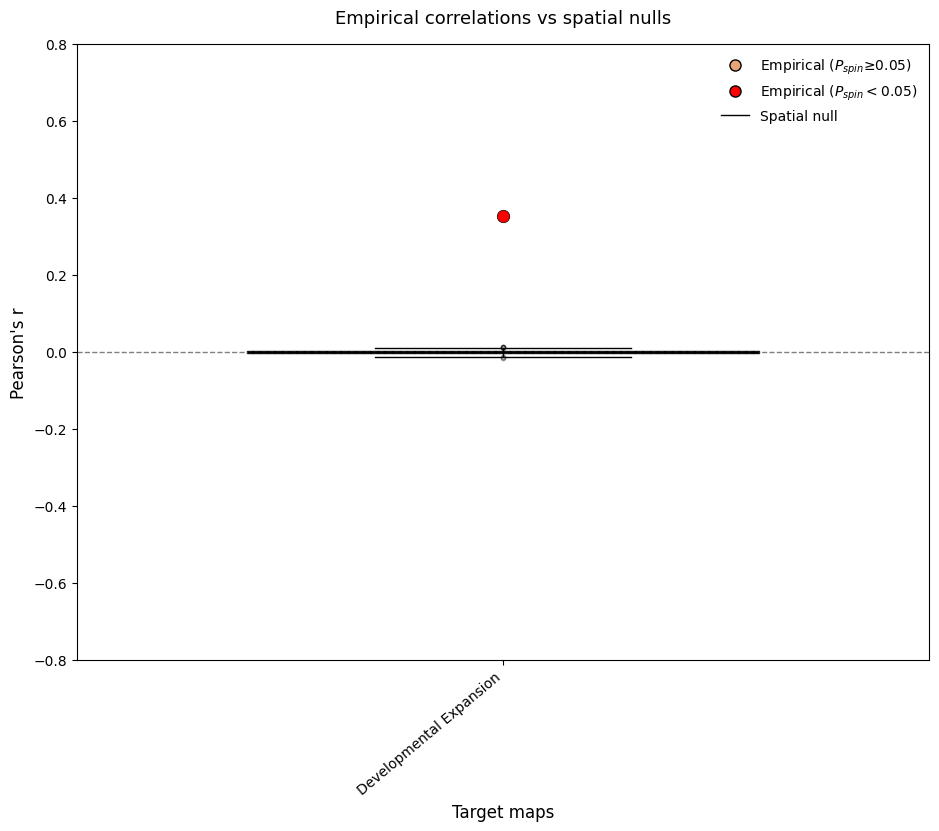

In [14]:
## code for box plots

results_df = pd.DataFrame(results_dict)

# check to make sure it's 1D array and not 2D
box_data = [np.ravel(np.array(n)) for n in results_df['nulls']]
positions = np.arange(1, len(box_data) + 1)

fig, ax = plt.subplots(figsize=(11, 8))

# boxplots for null dist
bp = ax.boxplot(
    box_data,
    positions=positions,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
    medianprops=dict(color='black', linewidth=1),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    flierprops=dict(marker='o', color='gray', markersize=3, alpha=0.4)
)

# add pearson r points
for i, (r, p) in enumerate(zip(results_df['r_emp'], results_df['p_spin'])):
    color = 'red' if p < 0.05 else '#e6a67a'
    ax.scatter(
        positions[i],
        r,
        color=color,
        s=80,
        edgecolor='black',
        linewidth=0.5,
        zorder=3
    )

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(results_df['target map'], rotation=40, ha='right', fontsize=10)
ax.set_ylabel("Pearson's r", fontsize=12)
ax.set_xlabel("Target maps", fontsize=12)
ax.set_ylim(-0.8, 0.8)
ax.set_title("Empirical correlations vs spatial nulls", fontsize=13, pad=15)

# legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Empirical ($P_{spin} ≥ 0.05$)',
           markerfacecolor='#e6a67a', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Empirical ($P_{spin} < 0.05$)',
           markerfacecolor='red', markeredgecolor='black', markersize=8),
    Line2D([0], [0], color='black', lw=1, label='Spatial null')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

In [ ]:
# # Find all indices where target == 'PC1 Gene Expression'
# # indices = [i for i, t in enumerate(results_dict['target map']) if t == 'PC1 Gene Expression']
# indices = [i for i, t in enumerate(results_dict['target map']) if t == 'Intersubject Variability']
# # indices = [i for i, t in enumerate(results_dict['target map']) if t == 'Developmental Expansion']

# # keep the newest version of target map
# if len(indices) > 1:
#     # get all but the last
#     to_remove = indices[:-1]

#     # remove from each list in the dictionary (in reverse order so indices don't shift)
#     for idx in sorted(to_remove, reverse=True):
#         for key in results_dict:
#             del results_dict[key][idx]

# print("cleaned results_dict")
# print(results_dict['target map'])


In [ ]:
#results_dict['target map']

In [ ]:
## Plotting Source map (fsLR 164k) to fsaverage 10k 

# load the data for the right hemi 
# evo_in_fsaverage10k = transforms.fslr_to_fsaverage(evo_map, '10k', hemi='R') should already have been ran but here if needed
rh_data = load_data(evo_in_fsaverage10k)

# fetches brain surface options for plotting
fslr = fetch_atlas('fsaverage', density='10k')
surf_r = fslr['inflated'].R # choose mid thickness for right hemi

vmin, vmax = -2.7, 2.7

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    surf_mesh=surf_r,
    surf_map=rh_data,
    hemi='right',
    cmap='plasma',
    bg_on_data=True,
    vmin=vmin,
    vmax=vmax,
    colorbar=False
)
# plot right veiw
plotting.plot_surf(
    view='lateral',
    axes=ax1,
    title='Hill 2010 Evolutionary Expansion (right hemisphere) in 10k',
    **plot_kwargs
)
# plot from left view
plotting.plot_surf(
    view='medial',
    axes=ax2,
    **plot_kwargs
)

sm = plt.cm.ScalarMappable(cmap='plasma')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Expansion (fsaverage 10k)', fontsize=11)
cbar.set_ticks([-2.7, 0, 2.7])

plt.show()

In [ ]:
## Plotting Source map (fsLR 164k) to fsLR 32k

# load the data for the right hemi 
# evo_in_fsLR32k = transforms.fslr_to_fslr(evo_map, '32k', hemi='R') # should already have been ran but here if needed
rh_data = load_data(evo_in_fsLR32k)

# fetches brain surface options for plotting
fslr = fetch_atlas('fsLR', density='32k')
surf_r = fslr['midthickness'].R # choose mid thickness for right hemi

vmin, vmax = -2.7, 2.7

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_kwargs = dict(
    surf_mesh=surf_r,
    surf_map=rh_data,
    hemi='right',
    cmap='plasma',
    bg_on_data=True,
    vmin=vmin,
    vmax=vmax,
    colorbar=False
)
# plot right veiw
plotting.plot_surf(
    view='lateral',
    axes=ax1,
    title='Hill 2010 Evolutionary Expansion (right hemisphere) in 32k',
    **plot_kwargs
)
# plot from left view
plotting.plot_surf(
    view='medial',
    axes=ax2,
    **plot_kwargs
)

sm = plt.cm.ScalarMappable(cmap='plasma')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('Expansion (fsLR 32k)', fontsize=11)
cbar.set_ticks([-2.7, 0, 2.7])

plt.show()

In [ ]:
# ## used to plot after FDR

# # --- Convert results_dict to DataFrame ---
# results_df = pd.DataFrame(results_dict)

# # --- Apply FDR correction ---
# p_vals = np.array(results_df['p_spin'])
# reject, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

# # Add FDR results to BOTH the DataFrame and dictionary
# results_df['p_fdr'] = p_fdr
# results_df['reject'] = reject
# results_dict['p_fdr'] = list(p_fdr)
# results_dict['reject'] = list(reject)

# # --- Clean the null distributions for boxplots ---
# box_data, valid_labels, valid_r, valid_sig = [], [], [], []

# for target, nulls, r, sig in zip(results_df['target map'],
#                                  results_df['nulls'],
#                                  results_df['r_emp'],
#                                  results_df['reject']):
#     nulls_arr = np.array(nulls)

#     # Flatten any 2D null arrays (from alexander_bloch)
#     if nulls_arr.ndim > 1:
#         nulls_arr = nulls_arr[:, ~np.all(np.isnan(nulls_arr), axis=0)]
#         nulls_arr = np.nanmean(nulls_arr, axis=1)

#     # Remove NaNs
#     nulls_clean = nulls_arr[~np.isnan(nulls_arr)]
#     if len(nulls_clean) < 5:
#         continue

#     box_data.append(nulls_clean)
#     valid_labels.append(target)
#     valid_r.append(r)
#     valid_sig.append(sig)

# # --- Plot ---
# positions = np.arange(1, len(box_data) + 1)
# fig, ax = plt.subplots(figsize=(11, 6))

# bp = ax.boxplot(
#     box_data,
#     positions=positions,
#     widths=0.6,
#     patch_artist=True,
#     boxprops=dict(facecolor='white', edgecolor='black', linewidth=1),
#     medianprops=dict(color='black', linewidth=1),
#     whiskerprops=dict(color='black'),
#     capprops=dict(color='black'),
#     flierprops=dict(marker='o', color='gray', markersize=3, alpha=0.4)
# )

# # --- Add empirical correlations ---
# for i, (r, sig) in enumerate(zip(valid_r, valid_sig)):
#     color = 'red' if sig else '#e6a67a'  # red = FDR-significant, orange = not significant
#     ax.scatter(
#         positions[i],
#         r,
#         color=color,
#         s=80,
#         edgecolor='black',
#         linewidth=0.5,
#         zorder=3
#     )

# # --- Axis formatting ---
# ax.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax.set_xticks(positions)
# ax.set_xticklabels(valid_labels, rotation=40, ha='right', fontsize=10)
# ax.set_ylabel("Pearson's r", fontsize=12)
# ax.set_xlabel("Target maps", fontsize=12)
# ax.set_title("Empirical correlations vs spatial nulls (FDR-corrected)", fontsize=13, pad=15)
# ax.set_ylim(-0.8, 0.8)

# # --- Legend ---
# legend_elements = [
#     Line2D([0], [0], marker='o', color='w',
#            label='Empirical (FDR ≥ 0.05)',
#            markerfacecolor='#e6a67a', markeredgecolor='black', markersize=8),
#     Line2D([0], [0], marker='o', color='w',
#            label='Empirical (FDR < 0.05)',
#            markerfacecolor='red', markeredgecolor='black', markersize=8),
#     Line2D([0], [0], color='black', lw=1, label='Spatial null')
# ]
# ax.legend(handles=legend_elements, loc='upper right', frameon=False)

# plt.show()
